# Dataprojekt Del 2
Denna notebook kommer innehålla följande steg:
- Data Pre-Processing: 
    - Slå ihop dataframes av samma typ men för olika tidsperioder
    - Ta bort dubbletter efter sammanslagning
    - Konvertera relevanta fält till passande data typ
    - join data för Nederbördstyp (från nu refererat till som 'typ'), luftfuktighet och lufttemperatur ('temp') till en dataframe, nyckel kommer att vara datum och tid 
- Data Exploration 
    - Plottning av det nya dataframen för att säkerställa att data inte innehåller outliners eller att data fattas
- Data Training
    - Uppdelning av dataset i tränings och validerings data 
    - Test och utvärdering av olika modeller 
- Ytterligare test av model 


Data källa: SMHI's väderstation _Stockholm-Observatoriekullen_.

In [117]:
# Import necessary lib
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#from xgboost import XGBClassifier
#from neuralprophet import NeuralProphet

In [27]:
# read CSV files

# TEMP
temp_12h = pd.read_csv('Del2_MetroData/Temp/smhi_lufttemperatur_minMax_12h.csv')
temp_12h_4m = pd.read_csv('Del2_MetroData/Temp/smhi_lufttemperatur_minMax_12h_4m.csv')
# TYP
type_12h  = pd.read_csv('Del2_MetroData/Nederbördstyp/smhi_nederbördstyp_12h.csv')
type_12h_4m  = pd.read_csv('Del2_MetroData/Nederbördstyp/smhi_nederbördstyp_12h_4m.csv')

# LUFT FKT 
humidity_h = pd.read_csv('Del2_MetroData/Luftfuktighet/smhi_relativ_luftfuktighet_h.csv')
humidity_h_4m = pd.read_csv('Del2_MetroData/Luftfuktighet/smhi_relativ_luftfuktighet_h_4m.csv')

## Data Pre-Processing

In [28]:
# Concat - Sammanslagning av dataframes

#TEMP
temp_frames = [temp_12h, temp_12h_4m]
temp = pd.concat(temp_frames)
temp_shape = temp.shape

#TYPE
type_frames = [type_12h, type_12h_4m]
type = pd.concat(type_frames)
type_shape = type.shape

#LUFT FKT 
humidity_frames = [humidity_h, humidity_h_4m]
humidity = pd.concat(humidity_frames)
humidity_shape = humidity.shape

# Control
print(f'Shape - Temp: {temp_shape},Type:{type_shape}, Luft fkt: {humidity_shape}')


Shape - Temp: (44206, 6),Type:(846, 4), Luft fkt: (231647, 4)


In [29]:
# Borttagning av dubbletter efter sammanslagning 
temp = temp.drop_duplicates()
type = type.drop_duplicates()
humidity = humidity.drop_duplicates()

# Control
temp_shape = temp.shape
type_shape = type.shape
humidity_shape = humidity.shape

print(f'Shape - Temp: {temp_shape},Type:{type_shape}, Luft fkt: {humidity_shape}')

Shape - Temp: (44151, 6),Type:(820, 4), Luft fkt: (230993, 4)


In [30]:
temp.dtypes

Datum                object
Tid (UTC)            object
Lufttemperatur      float64
Kvalitet             object
Lufttemperatur.1    float64
Kvalitet.1           object
dtype: object

In [34]:
# Konvertering av data type för samtliga Datum
temp['Datum'] = pd.to_datetime(temp['Datum'])
type['Datum'] = pd.to_datetime(type['Datum'])
humidity['Datum'] = pd.to_datetime(humidity['Datum'])

# Control
temp.dtypes
type.dtypes
humidity.dtypes

Datum                    datetime64[ns]
Tid (UTC)                        object
Relativ Luftfuktighet             int64
Kvalitet                         object
dtype: object

temp och types värden är uppmätta vid 18:00:00 och 06:00:00 medan humidity är uppmätt varje timme (se kommande 3 celler celler). Genom att göra en join på "Datum" och "Tid (UTC)" fås data för samma point in time. Som det observerades i den inledande data explorationen (Del 1) kommer dataframen Type att styra hur längden på tidsperioden eftersom detta är det minsta (och nyaste datasetet).

In [40]:
temp["Tid (UTC)"].value_counts()

Tid (UTC)
18:00:00    22776
06:00:00    21375
Name: count, dtype: int64

In [41]:
type["Tid (UTC)"].value_counts()

Tid (UTC)
18:00:00    420
06:00:00    400
Name: count, dtype: int64

In [42]:
humidity["Tid (UTC)"].value_counts()

Tid (UTC)
04:00:00    9638
20:00:00    9636
22:00:00    9635
01:00:00    9635
21:00:00    9635
23:00:00    9634
19:00:00    9633
02:00:00    9633
15:00:00    9633
03:00:00    9632
14:00:00    9631
17:00:00    9630
16:00:00    9629
07:00:00    9629
11:00:00    9626
13:00:00    9625
10:00:00    9624
09:00:00    9623
00:00:00    9621
08:00:00    9618
06:00:00    9612
18:00:00    9606
12:00:00    9590
05:00:00    9584
12:05:00       1
Name: count, dtype: int64

In [57]:
# join on ['Datum', 'Tid (UTC)'] för samtliga dataframes --> nycklarna kan återanvändas 

# keys
keys = ['Datum', 'Tid (UTC)']

# merge temp & type
temp_type = pd.merge(temp, type, on=keys)
#temp_type.head()

# merge temp_type med humidity 
data = pd.merge(temp_type, humidity, on=keys)

# Control
data.head()


,Datum,Tid (UTC),Lufttemperatur,Kvalitet_x,Lufttemperatur.1,Kvalitet.1,Nederbörd,Kvalitet_y,Relativ Luftfuktighet,Kvalitet
0,2019-10-07,18:00:00,1.4,G,8.8,G,regn,Y,83,G
1,2019-10-12,06:00:00,8.6,G,11.0,G,regn,Y,92,G
2,2019-10-14,06:00:00,7.6,G,10.7,G,regn,Y,97,G
3,2019-10-14,18:00:00,7.2,G,9.6,G,regn,Y,94,G
4,2019-10-17,06:00:00,6.8,G,8.3,G,regn,Y,97,G


In [90]:
# Drop unnecessary columns for ML (Kvalitet). Som fastslagits i Del 1, bedöms SMHI's självskattning (i egenskap av experter på mätning och tolkning av metrologiskt data) som trovärdig i kombination med good täckning (inga nollvärden för valda data). Eftersom den numreriskt uppmätta data (Temp och Luftfuktighet) har bedömt att ha en övervägande god kvalitet medan den mer subjektiva klassningen av typ en genomgående sämre kvalitet anses dessa inte vra nödvändiga features för ML.
data.drop(columns=['Kvalitet_x', 'Kvalitet.1', 'Kvalitet_y', 'Kvalitet'])

# Control
data.head()

KeyError: "['Kvalitet_x', 'Kvalitet.1', 'Kvalitet_y', 'Kvalitet'] not found in axis"

In [89]:
# Rename columns (Lufttemperatur och Lufttemperatur.1) till mer beskrivande namn
data.rename(columns = {'Lufttemperatur':'TempMin', 'Lufttemperatur.1':'TempMax'}, inplace = True)

# control
data.head()

,Datum,Tid (UTC),TempMin,TempMax,Nederbörd,Relativ Luftfuktighet
0,2019-10-07,18:00:00,1.4,8.8,3,83
1,2019-10-12,06:00:00,8.6,11.0,3,92
2,2019-10-14,06:00:00,7.6,10.7,3,97
3,2019-10-14,18:00:00,7.2,9.6,3,94
4,2019-10-17,06:00:00,6.8,8.3,3,97


In [59]:
data.dtypes

Datum                    datetime64[ns]
Tid (UTC)                        object
Lufttemperatur                  float64
Lufttemperatur.1                float64
Nederbörd                        object
Relativ Luftfuktighet             int64
dtype: object

In [102]:
data['Nederbörd'].value_counts()

# --> Obalanserad fördelning av klasser i datasetet 

Nederbörd
3    510
1    100
6     98
4     47
7     42
8     13
9      4
0      2
2      2
5      2
Name: count, dtype: int64

In [107]:
# Konvertera Nederbörd (labeln vi vill använda för ML) från data type object till int
data['Nederbörd']=LabelEncoder().fit_transform(data['Nederbörd'])

# Control
data.head()

,Datum,Tid (UTC),TempMin,TempMax,Nederbörd,Relativ Luftfuktighet,month
0,2019-10-07,18:00:00,1.4,8.8,3,83,October
1,2019-10-12,06:00:00,8.6,11.0,3,92,October
2,2019-10-14,06:00:00,7.6,10.7,3,97,October
3,2019-10-14,18:00:00,7.2,9.6,3,94,October
4,2019-10-17,06:00:00,6.8,8.3,3,97,October


## Data Exploration av sammanslaget och tvättat data

In [81]:
data['Nederbörd'].value_counts()

Nederbörd
3    510
1    100
6     98
4     47
7     42
8     13
9      4
0      2
2      2
5      2
Name: count, dtype: int64

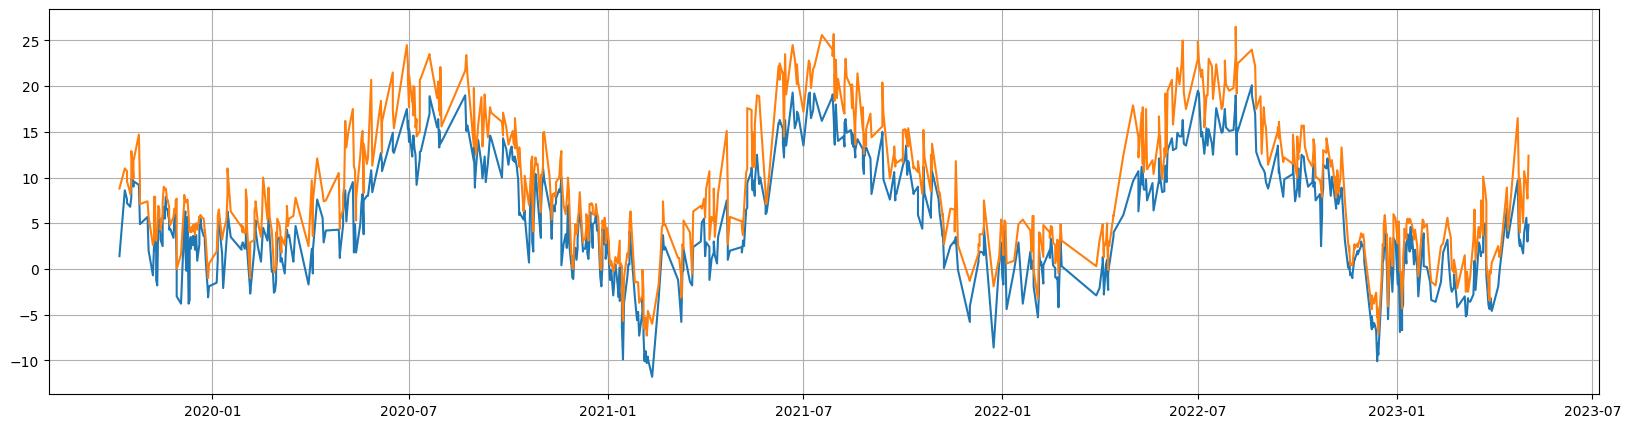

In [93]:
# Plot över tid för att säkerställa att datat inte innehåller några extrem värden (outliners) eller att data punkter fattas

plt.figure(figsize = (20, 5))
fig = plt.plot(data['Datum'], data[['TempMin', 'TempMax']])
plt.grid();

# ---> Plot visar som förvänta på cykliskt data med kallaste temp vid månaderna kring årsskiftet och varmast kring högsommar (juli-aug)

In [110]:
# Lägger till månads data för ytterligare aggregering 
data['Month'] = data['Datum'].dt.month_name()

# Control
data.head()
data.Month.value_counts()


Month
December     115
November     102
October       92
January       90
February      75
May           64
March         56
July          55
April         52
August        44
September     39
June          36
Name: count, dtype: int64

<Axes: xlabel='Month', ylabel='Nederbörd'>

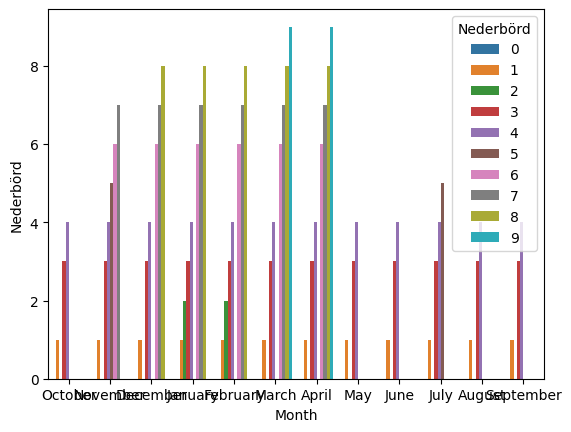

In [127]:
# TODO: Bättre graf
sns.barplot(data=data, x='Month',y='Nederbörd',hue='Nederbörd')

# Träning av ML modell

In [113]:
data.head()

,Datum,Tid (UTC),TempMin,TempMax,Nederbörd,Relativ Luftfuktighet,month,Month
0,2019-10-07,18:00:00,1.4,8.8,3,83,October,October
1,2019-10-12,06:00:00,8.6,11.0,3,92,October,October
2,2019-10-14,06:00:00,7.6,10.7,3,97,October,October
3,2019-10-14,18:00:00,7.2,9.6,3,94,October,October
4,2019-10-17,06:00:00,6.8,8.3,3,97,October,October


In [118]:
# Val av features 
features=['TempMax', 'TempMin', 'Relativ Luftfuktighet']
X=data[features]

# Val av labels
y=data.Nederbörd

# Split av data: test och träning
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)

In [126]:
# TODO lägg till fler Algoritmer
# Problem Typ: Klassificering
# Algoritm 1
# K-Nearest Neighbors Classifier

# Eftersom det tvättade datasetet är relativt litet (840 reader), ikce-linjärt problem av typ Klassificering anses KNN vara en lämplig algotitm.

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f'KNN Accuracy: {round(knn.score(X_test, y_test)*100)}%')


KNN Accuracy: 70%
